<h1>
<hr style=" border:none; height:3px;">
<center>Benchmark pipeline</center>
<hr style=" border:none; height:3px;">
</h1>

<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h4><center>Louis LHOTTE</center></h4>

# Introduction
<div style="background-color: #e3f2fd; padding: 15px; border-radius: 8px; border: 1px solid #81d4fa; display: flex; flex-direction: column; align-items: flex-start; max-width: 1125px;">
  <div style="display: flex; align-items: center; margin-bottom: 10px;">
    <img src="https://img.icons8.com/ios-filled/50/000000/info.png" alt="info" style="margin-right: 15px; width: 30px; height: 30px;">
    <span style="font-size: 16px; font-weight: bold; color: #01579b;">Information:</span>
  </div>
  <p style="font-size: 14px; color: #01579b;">
    After generating two batches of 8 images with four different comfyUI workflows, the database was annotated by humans to score three values: <br>
    - Logo Boolean Score (Yes/No)<br>
    - Aesthetic score (0-10)<br>
    - Business Score (0-10).<br><br>
    Thereafter, the goal is to compare those scores and see if the human feedback is correlated with two additional scores - <b>CLIP score</b> to calculate similarity between prompt and image, or <b>LLM custom scores</b> (with GPT-4o as annotator) detailed in scientific papers - see notes<br>
    For the record, the database was <b>NOT</b> annotated by myself, who generated the logo to avoid any bias.
  </p>
</div>


# 0 - Imports

In [29]:
import pandas as pd
from __future__ import annotations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go


# I - Human Scores

## I.1 - Pre-processing

In [45]:
# df: pd.Dataframe = pd.read_csv('Logo Stable Diffusion Test.csv', delimiter=";")
df: pd.Dataframe = pd.read_csv('all.csv')
bool_mapping: dict = {'Oui': 1, 'Non': 0}
df = df.dropna()
df['Is it a logo?'] = df['Is it a logo?'].apply(lambda x: bool_mapping[x])
df = df.replace(-10, 0)
df.head(2)

,Image,Is it a logo?,Score esthéthique (0-10),Score business (0-10)
1,best_00001,1,8.0,7.0
2,best_00009_,1,7.0,8.0


In [46]:
pattern_to_category_mapping: dict = {
    'D8 Lhotte': 'Lhotte-v3 LoRA - Dreamshaper v8',
    'Sd15 Lhotte': 'Lhotte-v3 LoRA - Stable Diffusion pruned 1.5',
    'D8 RedmondV2': 'RedmondV2 LoRA - Dreamshaper v8',
    'Sd15 RedmondV2': 'RedmondV2 LoRA - Stable Diffusion pruned 1.5',
    'LEDITS': "LEDITS++",
    'best': "Lhotte-v3 LoRA + DS8 (pruned)"
}
def categorize(filename: str) -> str:
    for pattern, category in pattern_to_category_mapping.items():
        if pattern in filename:
            return category
    return 'Uknown'

df['Model'] = df['Image'].apply(categorize)
df.head(2)

,Image,Is it a logo?,Score esthéthique (0-10),Score business (0-10),Model
1,best_00001,1,8.0,7.0,Lhotte-v3 LoRA + DS8 (pruned)
2,best_00009_,1,7.0,8.0,Lhotte-v3 LoRA + DS8 (pruned)


In [47]:
df['Model'].value_counts()

Model
Lhotte-v3 LoRA + DS8 (pruned)                   24
LEDITS++                                        24
Lhotte-v3 LoRA - Stable Diffusion pruned 1.5    24
RedmondV2 LoRA - Dreamshaper v8                 24
Lhotte-v3 LoRA - Dreamshaper v8                 24
RedmondV2 LoRA - Stable Diffusion pruned 1.5    24
Name: count, dtype: int64

## I.2 - Visualisation

### I.2.1 - Confusion matrix


<div class="alert alert-block alert-info">In this part, we are trying to plot the <b>pseudo-accuracy</b> of each model in a <b>confusion matrix</b>, using the human annotations of the column 'Is it a logo?'. In other words, we interpret human perception (whether an image aligns with the general impression of a logo) as the 'truth' labels for a classification problem.
</div>

In [48]:
conf_matrix = df.groupby(['Model', 'Is it a logo?']).size().unstack(fill_value=0)

# Manually wrap y-axis labels (Model names)
def wrap_label(label, width=15):
    return '<br>'.join([label[i:i+width] for i in range(0, len(label), width)])

wrapped_y_labels = [wrap_label(str(label)) for label in conf_matrix.index]

# Plotly heatmap
fig = go.Figure(data=go.Heatmap(
    z=conf_matrix.values,
    x=conf_matrix.columns.astype(str),
    y=wrapped_y_labels,
    colorscale='Blues',
    showscale=True,
    text=conf_matrix.values,
    texttemplate="%{text}",
    hovertemplate="Model: %{y}<br>Logo Score: %{x}<br>Count: %{z}<extra></extra>"
))

# Layout
fig.update_layout(
    title={
        'text': 'Confusion Matrix of Human Logo Annotations per Model',
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(family='serif', size=14)
    },
    xaxis_title='Logo Score (0 = Not a logo, 1 = Logo)',
    yaxis_title='Model',
    xaxis=dict(tickfont=dict(family='serif', size=10)),
    yaxis=dict(tickfont=dict(family='serif', size=10)),
    width=600,
    height=500,
    margin=dict(l=80, r=40, t=60, b=40)
)

fig.show()

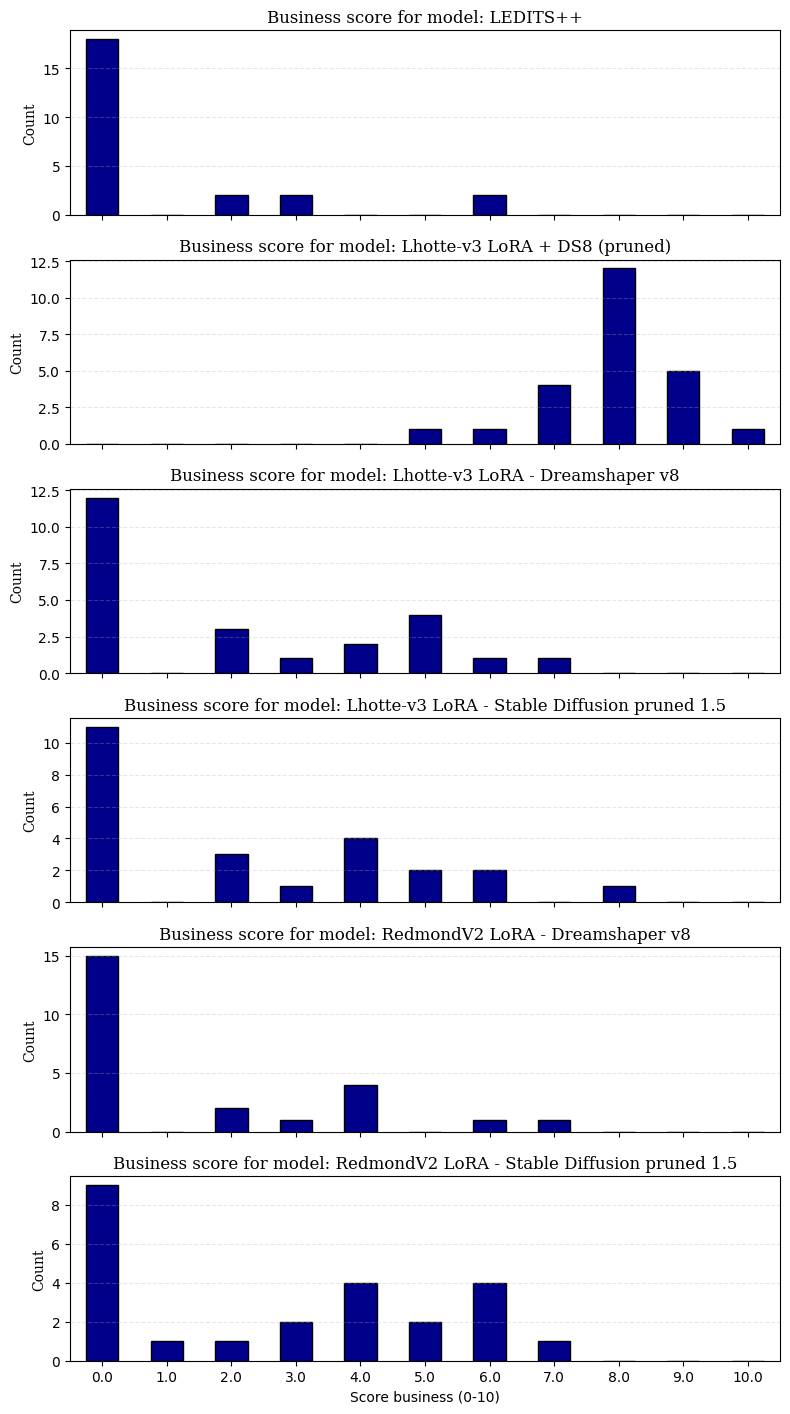

In [49]:
conf_matrix = df.groupby(['Model', 'Score business (0-10)']).size().unstack(fill_value=0)
models = conf_matrix.index

fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(8, 2.5 * len(models)), sharex=True)
for ax, model in zip(axes, models):
    conf_matrix.loc[model].plot(kind='bar', color='darkblue', edgecolor='black', ax=ax)
    ax.set_title(f'Business score for model: {model}', fontfamily='serif', fontsize=12)
    ax.set_ylabel('Count', fontfamily='serif', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_xticks(range(len(conf_matrix.columns)))
    ax.set_xticklabels(conf_matrix.columns, rotation=0, fontsize=10)  
plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.show()


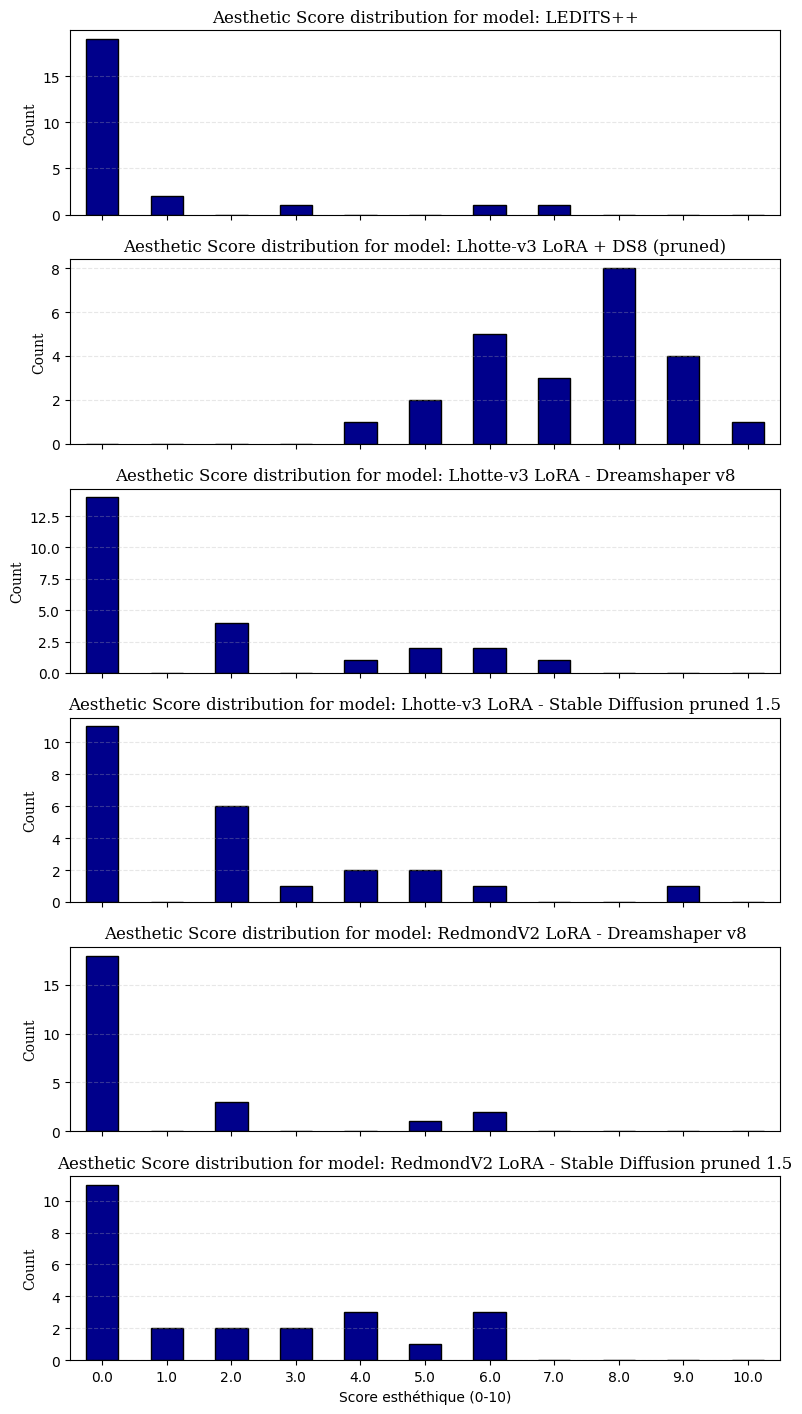

In [50]:
conf_matrix = df.groupby(['Model', 'Score esthéthique (0-10)']).size().unstack(fill_value=0)
models = conf_matrix.index


fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(8, 2.5 * len(models)), sharex=True)
for ax, model in zip(axes, models):
    conf_matrix.loc[model].plot(kind='bar', color='darkblue', edgecolor='black', ax=ax)
    ax.set_title(f'Aesthetic Score distribution for model: {model}', fontfamily='serif', fontsize=12)
    ax.set_ylabel('Count', fontfamily='serif', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_xticks(range(len(conf_matrix.columns)))
    ax.set_xticklabels(conf_matrix.columns, rotation=0, fontsize=10)  

plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.show()

<Figure size 600x500 with 0 Axes>

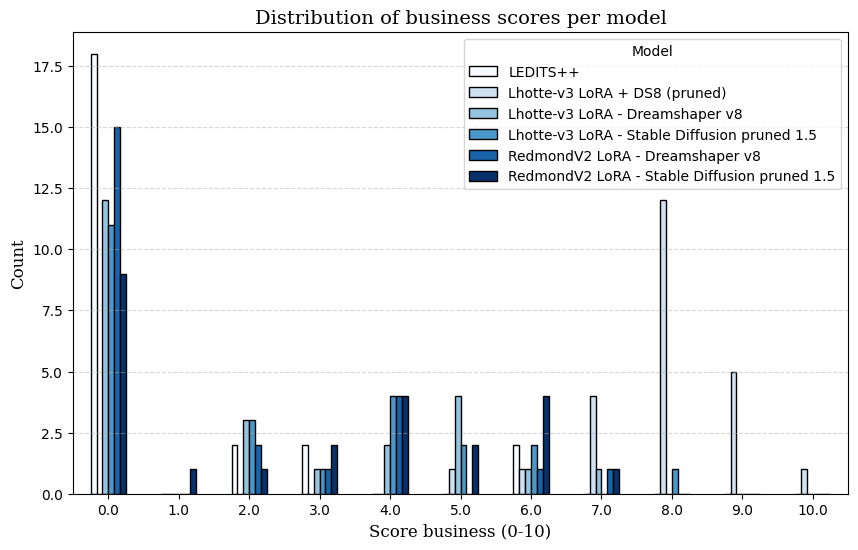

In [51]:
conf_matrix = df.groupby(['Model', 'Score business (0-10)']).size().unstack(fill_value=0)

# Plotting the grouped bar chart
plt.figure(figsize=(6, 5))
conf_matrix.T.plot(kind='bar', stacked=False, figsize=(10, 6), colormap='Blues', edgecolor='black')

plt.xlabel('Score business (0-10)', fontfamily='serif', fontsize=12)
plt.ylabel('Count', fontfamily='serif', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Model', bbox_to_anchor=(1, 1))
plt.title('Distribution of business scores per model', fontfamily='serif', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [74]:
import plotly.graph_objects as go
import pandas as pd

mean_scores = df.groupby('Model')['Score esthéthique (0-10)'].mean().sort_values(ascending=False)
df = df.copy()
df['Model'] = pd.Categorical(df['Model'], categories=mean_scores.index, ordered=True)

wrapped_labels = [label.replace(" ", "<br>") for label in mean_scores.index]

fig = go.Figure()

for model in mean_scores.index:
    fig.add_trace(go.Violin(
        y=df[df['Model'] == model]['Score esthéthique (0-10)'],
        name=model,  # Unwrapped for the legend
        box_visible=True,
        meanline_visible=True,
        points='all',
        width=0.4,
        scalemode='width',
        spanmode='soft'
    ))

fig.update_layout(
    title='Distribution of Aesthetic Scores per Model (Ranked by Mean Score)',
    xaxis_title='Model',
    yaxis_title='Aesthetic Score (0-10)',
    font=dict(family='Serif', size=12),
    width=1100,
    height=500,
    violingap=0.15,
    template='simple_white'
)

fig.update_xaxes(
    tickvals=list(mean_scores.index),
    ticktext=wrapped_labels
)

fig.show()

C:\Users\Louis\AppData\Local\Temp\ipykernel_12916\4153336100.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [75]:
import plotly.graph_objects as go
import pandas as pd

mean_scores = df.groupby('Model')['Score business (0-10)'].mean().sort_values(ascending=False)
df = df.copy()
df['Model'] = pd.Categorical(df['Model'], categories=mean_scores.index, ordered=True)

wrapped_labels = [label.replace(" ", "<br>") for label in mean_scores.index]

fig = go.Figure()

for model in mean_scores.index:
    fig.add_trace(go.Violin(
        y=df[df['Model'] == model]['Score business (0-10)'],
        name=model,  # Unwrapped for the legend
        box_visible=True,
        meanline_visible=True,
        points='all',
        width=0.4,
        scalemode='width',
        spanmode='soft'
    ))

fig.update_layout(
    title='Distribution of Business Scores per Model (Ranked by Mean Score)',
    xaxis_title='Model',
    yaxis_title='Score business (0-10)',
    font=dict(family='Serif', size=12),
    width=1100,
    height=500,
    violingap=0.15,
    template='simple_white'
)

fig.update_xaxes(
    tickvals=list(mean_scores.index),
    ticktext=wrapped_labels
)

fig.show()

C:\Users\Louis\AppData\Local\Temp\ipykernel_12916\2390600028.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



# II - GPT-4o Score

<div class='alert alert-block alert-info'>Use of gpt-4o using the formula used in litterature : 𝑺_𝑳𝑳𝑴=𝟎,𝟒 ∗𝑺_𝒂𝒄𝒄+𝟎,𝟑 ∗ 𝑺_𝒑𝒓𝒆+𝟎,𝟐∗𝑺_𝒒𝒖𝒂+𝟎,𝟏∗𝑺_𝒓𝒆𝒂𝒍</div>

In [21]:
df_gpt = pd.read_csv('LLM_Score_Evaluation_Results.csv', delimiter=';')
df_gpt = df_gpt.drop(columns=['S_qua'])
df_gpt

,Image Name,S_acc,S_pre,S_real,S_LLM
0,best_00001.png,0.887988,0.812648,0.841521,0.883142
1,best_00009_.png,0.814461,0.665661,0.958941,0.821377
2,best_00013_.png,0.798146,0.968754,0.968244,0.906709
3,best_00016_.png,0.905635,0.857895,0.806411,0.900264
4,best_00017_.png,0.763197,0.905924,0.812215,0.858277
...,...,...,...,...,...
140,Sd15 RedmondV2_00020_.png,0.938623,0.870834,0.909575,0.871298
141,Sd15 RedmondV2_00021_.png,0.801308,0.739503,0.822374,0.824611
142,Sd15 RedmondV2_00022_.png,0.928026,0.606464,0.874388,0.840588
143,Sd15 RedmondV2_00023_.png,0.985108,0.937547,0.955276,0.939614


array([[<Axes: title={'center': 'S_acc'}>,
        <Axes: title={'center': 'S_pre'}>],
       [<Axes: title={'center': 'S_real'}>,
        <Axes: title={'center': 'S_LLM'}>]], dtype=object)

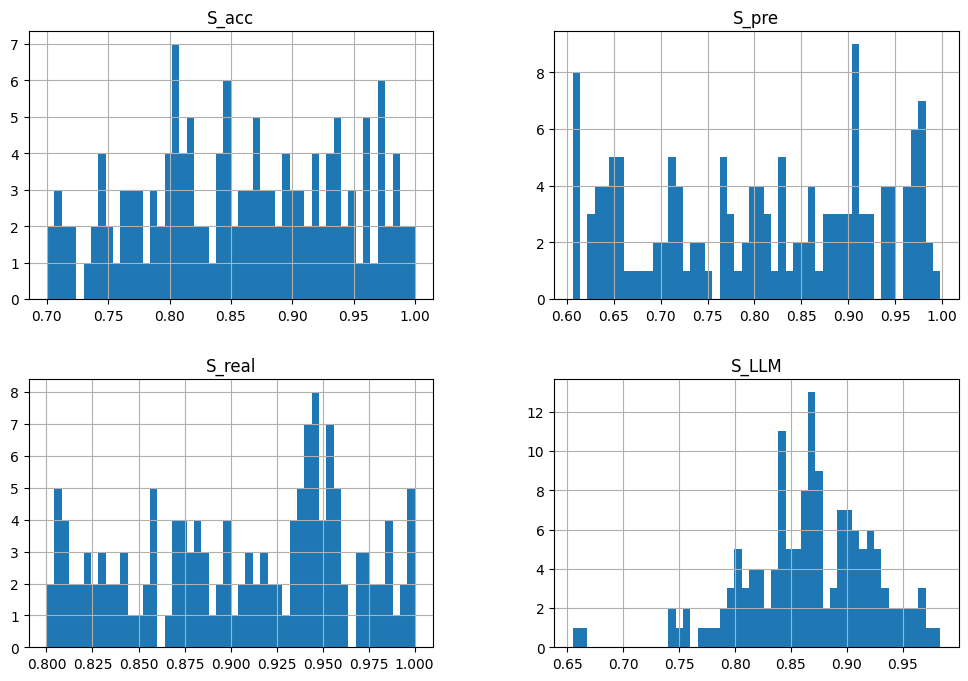

In [22]:
df_gpt.hist(figsize=(12,8), bins=50)

In [27]:
import plotly.express as px
import pandas as pd

# Extract prefix from image names
df_gpt["Prefix"] = df_gpt["Image Name"].apply(lambda x: x.split('_')[0].split('-')[0])

# Sort prefixes by mean S_LLM
mean_scores = df_gpt.groupby("Prefix")["S_LLM"].mean().reset_index()
mean_scores = mean_scores.sort_values(by="S_LLM", ascending=False)
ordered_prefixes = mean_scores["Prefix"]

# Create a box plot with strip (jitter) plot overlay
fig = px.box(
    df_gpt,
    x="Prefix",
    y="S_LLM",
    points="all",  # Shows all points with jitter
    color="Prefix",  # Different color per prefix
    category_orders={"Prefix": ordered_prefixes},
    color_discrete_sequence=px.colors.qualitative.Set3,  # Vibrant distinct colors
)

# Customize layout
fig.update_layout(
    title="Distribution of S_LLM Scores (ranked by means)",
    xaxis_title="Image Prefix",
    yaxis_title="S_LLM Score",
    font=dict(family="serif"),
    xaxis=dict(tickangle=45),
    yaxis=dict(gridcolor="rgba(0,0,0,0.1)"),
    height=600,
    width=1000,
    plot_bgcolor="white",
    showlegend=True
)

fig.show()


# III - CLIP Score

In [4]:
import torch
import clip
from PIL import Image
import pandas as pd
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image_folder = "C:\\Users\\Louis\\Desktop\\img\\"
prompt = "logo, logo for a business company, minimalist"

image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
images = [preprocess(Image.open(os.path.join(image_folder, img))).unsqueeze(0).to(device) for img in image_files]
text = clip.tokenize([prompt]).to(device)
scores = []

In [3]:
with torch.no_grad():
    text_features = model.encode_text(text)
    for img_tensor in images:
        image_features = model.encode_image(img_tensor)
        similarity = (image_features @ text_features.T).squeeze().item()
        scores.append(similarity)

df = pd.DataFrame({"image": image_files, "clip_score": scores})
print(df)

c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


                         image  clip_score
0               best_00001.png   25.562500
1              best_00009_.png   21.906250
2              best_00013_.png   20.718750
3              best_00016_.png   20.515625
4              best_00017_.png   20.390625
..                         ...         ...
140  Sd15 RedmondV2_00020_.png   19.625000
141  Sd15 RedmondV2_00021_.png   24.062500
142  Sd15 RedmondV2_00022_.png   25.015625
143  Sd15 RedmondV2_00023_.png   22.140625
144  Sd15 RedmondV2_00024_.png   25.812500

[145 rows x 2 columns]


In [8]:
pattern_to_category_mapping: dict = {
    'D8 Lhotte': 'Lhotte-v3 LoRA - D8',
    'Sd15 Lhotte': 'Lhotte-v3 LoRA - SD1.5',
    'D8 RedmondV2': 'RedmondV2 LoRA - D8',
    'Sd15 RedmondV2': 'RedmondV2 LoRA - SD1.5',
    'LEDITS': "LEDITS++",
    "best": "Lhotte-v3 LoRA + D8 (pruned)"
}
def categorize(filename: str) -> str:
    for pattern, category in pattern_to_category_mapping.items():
        if pattern in filename:
            return category
    return 'Uknown'

df['Model'] = df['image'].apply(categorize)
df

,image,clip_score,Model,clip_score_norm
0,best_00001.png,25.562500,Lhotte-v3 LoRA + D8 (pruned),0.938073
1,best_00009_.png,21.906250,Lhotte-v3 LoRA + D8 (pruned),0.803899
2,best_00013_.png,20.718750,Lhotte-v3 LoRA + D8 (pruned),0.760321
3,best_00016_.png,20.515625,Lhotte-v3 LoRA + D8 (pruned),0.752867
4,best_00017_.png,20.390625,Lhotte-v3 LoRA + D8 (pruned),0.748280
...,...,...,...,...
140,Sd15 RedmondV2_00020_.png,19.625000,RedmondV2 LoRA - SD1.5,0.720183
141,Sd15 RedmondV2_00021_.png,24.062500,RedmondV2 LoRA - SD1.5,0.883028
142,Sd15 RedmondV2_00022_.png,25.015625,RedmondV2 LoRA - SD1.5,0.918005
143,Sd15 RedmondV2_00023_.png,22.140625,RedmondV2 LoRA - SD1.5,0.812500


In [27]:
import plotly.express as px

df['clip_score_norm'] = df['clip_score'] / df['clip_score'].max()
grouped = df.groupby('Model')['clip_score_norm'].mean().reset_index()
grouped = grouped.sort_values(by='clip_score_norm', ascending=False)

fig = px.bar(grouped,
             x='Model',
             y='clip_score_norm',
             text='clip_score_norm',
             title='Normalized Mean CLIP Score by Model',
             labels={'clip_score_norm': 'Normalized Mean CLIP Score'},
             template='simple_white',
             color='clip_score_norm',
             color_continuous_scale='Viridis')

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    font_family='Serif',
    xaxis_title='Model Category',
    yaxis_title='Normalized CLIP Score (Mean)',
    title_x=0.5,
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    coloraxis_showscale=True
)
fig.show()

C:\Users\Louis\AppData\Local\Temp\ipykernel_1436\1688427553.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [24]:
import plotly.express as px

df['clip_score_norm'] = df['clip_score'] / df['clip_score'].max()
mean_scores = df.groupby('Model')['clip_score_norm'].mean().sort_values(ascending=False)

df['Model_sorted'] = pd.Categorical(df['Model'], categories=mean_scores.index, ordered=True)

fig = px.violin(df,
                x='Model_sorted',
                y='clip_score_norm',
                box=True,
                points='all',
                color='Model_sorted',
                category_orders={'Model_sorted': mean_scores.index.tolist()},
                color_discrete_sequence=px.colors.sequential.Viridis,
                title='Distribution of Normalized CLIP Scores by Model',
                template='simple_white')

fig.update_layout(
    font_family='Serif',
    xaxis_title='Model Category',
    yaxis_title='Normalized CLIP Score',
    title_x=0.5,
    showlegend=True
)
fig.show()


C:\Users\Louis\AppData\Local\Temp\ipykernel_1436\3028388774.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

